## Predicting Employee productivity using Tree Models

This project uses a dataset that contains information abut garment employees and implement Decision Tree models on the dataset to predict the productivity of the employees.
Each column of the dataset represents: 
- `date`: date in MM-DD-YYYY
- `quarter`: a portion of the month — month was divided into four quarters
- `department`: associated department with the instance
- `day`: day of the week
- `team`: associated team number with the instance
- `targeted_productivity`: targeted productivity set by the authority for each team for each day
- `smv`: standard minute value — the allocated time for a task
- `wip`: work in progress — includes the number of unfinished items for products
- `over_time`: represents the amount of overtime by each team in minutes
- `incentive`: represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action
- `idle_time`: the duration of time when the production was interrupted due to several reasons
- `idle_men`: the number of workers who were idle due to production interruption
- `no_of_style_change`: number of changes in the style of a particular product
- `no_of_workers`: number of workers on each team
- `actual_productivity`: the actual % of productivity that was delivered by the workers — it ranges from 0 to 1.

In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option('display.max_columns', None)
import seaborn as sns
import datetime as dt
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

In [307]:
df=pd.read_csv('garments_worker_productivity.csv')
display(df.head())

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


### Exploring the Dataset

In [308]:
print(df.shape)

(1197, 15)


The dataframe has 1197 observations and 15 columns, out of which 14 of them are attributes/feature columns when the target varaible `actual_productivity` is kept aside. 

In [309]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

- Dataset contains columns of both numeric and non numeric dtypes. 
- `date`,`quarter`,`deartment`,`day` are the only columns with object dtypes while rest of the columns belong to numeric dtype.

In [310]:
display(df.describe())

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


- Fundamental statistical values gained in above for each columns is important is understanding the distribution of data in each columns and idetifying the presence of outliers.
- There are few columns such as `wip`,`over_time`,`incetive`,`idle_time`,`idle_men`,`no_of_workers` that has maximum value way higher than the 75% percentile of the data, which indicates the presence of outliers in the data.
- `wip` and `over_time` columns have their minimum values way lesser than the 25% percentile of data which also convince presence of string outliers in those columns. 
- Range of values for each columns differs widely, which indeed should be scaled or standerdized before using these values in the data model. 
- There is a quite high average `over_time` with instances which are even way higher as indicated in the hugely disproportiante max value. This indicates the workers are struggling to acheive the production targets only by working during the regular work hours which could be due to various reasons.
- Number of workers ranges from 2 to 89, where average number in a team is around 35.This indicates depending on the functionality/purpose of the team, the number of workers may be varied indicating teams with easier tasks would require only few people as less as 2 and teams with complex, time consuming tasks would require more people as large as 89 to efficiently perform in order to acheive productivity goals. 

In [311]:
print(df.isnull().sum())

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64


- `wip` column has **506** null values, which makes it need further investigation on the unique values of this attribute.
- With the investigation, it can be noticed this attribute has a large array of distinct values which included nan vlaues as one of the unique values. 
- nan values could imply, the instances when there was no any unfinished items for products were left, or no wip. 
- So,these nan values could be replaced with zero before using in Machine Learning models for data analysis process. 

In [312]:
# Calculating the unique value count for each feature column. 
# Target variable 'actual_productivity` is excluded and it has a continuous numeric value.
for col in df.columns[:-1]:
    print(df[col].value_counts())

3/11/2015    24
1/31/2015    24
1/11/2015    23
3/10/2015    23
1/12/2015    23
1/24/2015    23
1/8/2015     22
1/10/2015    22
1/7/2015     22
1/13/2015    22
1/5/2015     22
3/9/2015     22
3/8/2015     22
3/3/2015     22
1/22/2015    22
2/25/2015    21
2/26/2015    21
2/28/2015    21
1/3/2015     21
1/4/2015     21
1/28/2015    21
1/27/2015    21
3/4/2015     21
1/25/2015    21
1/17/2015    21
1/14/2015    21
1/6/2015     21
2/18/2015    21
1/29/2015    20
2/17/2015    20
3/2/2015     20
3/1/2015     20
2/22/2015    20
2/19/2015    20
3/5/2015     19
3/7/2015     19
2/24/2015    19
2/23/2015    19
1/1/2015     19
2/3/2015     19
2/15/2015    19
1/15/2015    19
1/18/2015    19
1/19/2015    19
1/21/2015    19
1/26/2015    19
2/1/2015     19
2/2/2015     19
2/4/2015     19
2/7/2015     19
2/8/2015     19
2/10/2015    19
2/11/2015    19
2/12/2015    19
2/5/2015     18
2/9/2015     18
2/16/2015    18
2/14/2015    17
1/20/2015    15
Name: date, dtype: int64
Quarter1    360
Quarter2    335

- Gaining insights from each column:

**--Date--**
- By looking at the leading five and trailing five observations as below we can identify the selected time period for this dataset. 
- So, all observations are collected in the period of **1/1/2015 to 3/11/2015**

In [313]:
display(df.head())
print('\n')
display(df.tail())

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.9,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.9,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.9,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.9,NaN,1800,0,0.0,0,0,15.0,0.505889
1196,3/11/2015,Quarter2,finishing,Wednesday,6,0.70,2.9,NaN,720,0,0.0,0,0,6.0,0.394722



 **-- Quarter--**
- Description for the `quarter` columns says, the year is divided into four quarters. But in this dataset there are five quarters present. 
- So,let's further investigate the observations that has **Quarter5**

In [314]:
display(df[df['quarter']=='Quarter5'])

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
498,1/29/2015,Quarter5,sweing,Thursday,2,0.80,22.52,1416.0,6840,113,0.0,0,0,57.0,1.000230
499,1/29/2015,Quarter5,finishing,Thursday,4,0.80,4.30,NaN,1200,0,0.0,0,0,10.0,0.989000
500,1/29/2015,Quarter5,sweing,Thursday,3,0.80,22.52,1287.0,6840,100,0.0,0,0,57.0,0.950186
501,1/29/2015,Quarter5,sweing,Thursday,4,0.80,22.52,1444.0,6900,88,0.0,0,0,57.5,0.900800
502,1/29/2015,Quarter5,sweing,Thursday,10,0.80,22.52,1088.0,6720,88,0.0,0,0,56.0,0.900130
503,1/29/2015,Quarter5,finishing,Thursday,6,0.50,2.90,NaN,1200,0,0.0,0,0,10.0,0.899000
504,1/29/2015,Quarter5,finishing,Thursday,8,0.65,4.15,NaN,960,0,0.0,0,0,8.0,0.877552
505,1/29/2015,Quarter5,finishing,Thursday,11,0.60,2.90,NaN,960,0,0.0,0,0,8.0,0.864583
506,1/29/2015,Quarter5,finishing,Thursday,10,0.80,3.94,NaN,1200,0,0.0,0,0,10.0,0.856950
507,1/29/2015,Quarter5,finishing,Thursday,1,0.75,3.94,NaN,1200,0,0.0,0,0,10.0,0.853667


- All dates that are belonged to **Quarter5** are either 29 th or 31st of the month of January and it has skipped 30th. 
- 29 th and 31st correspond with Thursdays and Saturdays and skipped 30th date which happen to be Friday of the selected time period.
- This provides the information that the last two production days of the January month are considered as a new quarter. 
- In the sametime, this information leads further investigation on Fridays of the dataset, to understand why 30th which was a Friday was not considred as one of the last two production days of the January. 

 **-- day--**
- Description for the `day` columns says, day of the week, although there are no **Fridays** in the datset.
- This explains the reason why 30th was skipped as one of the last two days in the Quarter5 of January.
- This indicates, Friday could be a factory closed day or an all employee holiday. 

 **-- wip--**
- This column has two similar ditinct values for **finishing**, which indicates one of them have trailing or leading white spaces. 
- So, that white spaces should be removed during the data cleaning step to avoid duplicate of unique classes.

**--incetive--**
- Based on the description `incetive` indicates the financial incentive that motivates particular cousrse of action. 
- In the dataset almost 50% of the data which is 1179 observations had no any incetives.

**--idle_time-- AND  --idle_men--**
- There are 1179 observations without any interruptions to the production process and 1050 observations where no workers had to been idle during production process. 
- These numbers indicate there are few occurences where the production process was idle and people have to be idle. 

In [315]:
display(df[(df['idle_time'] > 0) & (df['idle_men'] >0)])

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
615,2/4/2015,Quarter1,sweing,Wednesday,5,0.65,30.10,326.0,5820,0,90.0,10,0,58.5,0.650835
617,2/4/2015,Quarter1,sweing,Wednesday,4,0.35,30.10,287.0,6060,23,150.0,15,0,55.5,0.350706
650,2/7/2015,Quarter1,sweing,Saturday,7,0.70,24.26,658.0,6960,0,270.0,45,0,58.0,0.662270
654,2/7/2015,Quarter1,sweing,Saturday,8,0.70,24.26,652.0,6840,0,300.0,37,0,57.0,0.365319
775,2/15/2015,Quarter3,sweing,Sunday,8,0.70,30.10,507.0,5880,40,2.0,10,1,59.0,0.700573
798,2/16/2015,Quarter3,sweing,Monday,8,0.70,30.10,7.0,7080,27,2.0,10,2,59.0,0.621972
818,2/17/2015,Quarter3,sweing,Tuesday,8,0.60,29.40,179.0,0,23,5.0,30,2,58.0,0.600983
822,2/17/2015,Quarter3,sweing,Tuesday,10,0.65,18.22,741.0,0,0,8.0,35,1,49.0,0.302117
841,2/18/2015,Quarter3,sweing,Wednesday,10,0.70,19.68,1119.0,5640,0,8.0,35,1,47.0,0.303574
843,2/18/2015,Quarter3,sweing,Wednesday,8,0.65,29.40,962.0,4560,0,4.5,30,2,57.0,0.251399


- At **18** instances, when the `idle_time` was larger than 0 which indicates interruptions in the production process, workers in the groups ranging from 10 to 49 people had to stay idle.

**-- taget_productivity-- AND --actual_productivity--**

In [316]:
productivity=pd.DataFrame(data={'y_target':df['targeted_productivity'],'y_actual':df['actual_productivity'],'difference':df['actual_productivity']-
    df['targeted_productivity']}) 
display(productivity)

,y_target,y_actual,difference
0,0.80,0.940725,0.140725
1,0.75,0.886500,0.136500
2,0.80,0.800570,0.000570
3,0.80,0.800570,0.000570
4,0.80,0.800382,0.000382
...,...,...,...
1192,0.75,0.628333,-0.121667
1193,0.70,0.625625,-0.074375
1194,0.65,0.625625,-0.024375
1195,0.75,0.505889,-0.244111


In [317]:
# Calculating the observations with actual-prouctivity larger than or equal to target_productivity
display(productivity[productivity['y_actual']>productivity['y_target']])

,y_target,y_actual,difference
0,0.80,0.940725,0.140725
1,0.75,0.886500,0.136500
2,0.80,0.800570,0.000570
3,0.80,0.800570,0.000570
4,0.80,0.800382,0.000382
...,...,...,...
1187,0.75,0.750051,0.000051
1188,0.70,0.700557,0.000557
1189,0.70,0.700505,0.000505
1190,0.70,0.700246,0.000246


- Based on the comparison of actual and target values for productivity, there are observations with both instances ,where actual production was higher as well as lower than the target production for each team for each day.
- Out of them there are 869 observations which is 73% of data have the `actual_productivity` greater than `target_productivity`.

In [318]:
display(productivity[productivity['y_actual']>=productivity['y_target']])

,y_target,y_actual,difference
0,0.80,0.940725,0.140725
1,0.75,0.886500,0.136500
2,0.80,0.800570,0.000570
3,0.80,0.800570,0.000570
4,0.80,0.800382,0.000382
...,...,...,...
1187,0.75,0.750051,0.000051
1188,0.70,0.700557,0.000557
1189,0.70,0.700505,0.000505
1190,0.70,0.700246,0.000246


- Out of 875 observations, 869 of them had actual productivity higher tha targeted productivity, which means only 6 observations had the actual productivity equal to the targeted productivity.

In [319]:
# Exploring higher actual_productivity acheived with no overtime
display(df[(df['over_time']==0 & (df['actual_productivity']>=df['targeted_productivity']))])

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
684,2/9/2015,Quarter2,sweing,Monday,11,0.75,10.05,103.0,0,45,0.0,0,0,54.0,0.750648
694,2/10/2015,Quarter2,sweing,Tuesday,10,0.80,22.52,1268.0,0,88,0.0,0,0,56.0,0.900632
695,2/10/2015,Quarter2,sweing,Tuesday,1,0.80,22.52,1546.0,0,88,0.0,0,0,57.0,0.900471
696,2/10/2015,Quarter2,sweing,Tuesday,3,0.80,22.52,813.0,0,88,0.0,0,0,57.0,0.900471
697,2/10/2015,Quarter2,sweing,Tuesday,2,0.80,22.52,1512.0,0,88,0.0,0,0,57.0,0.899984
713,2/11/2015,Quarter2,sweing,Wednesday,2,0.80,22.52,1557.0,0,90,0.0,0,0,57.5,1.000345
714,2/11/2015,Quarter2,sweing,Wednesday,1,0.80,22.52,1498.0,0,113,0.0,0,0,57.0,1.000066
718,2/11/2015,Quarter2,sweing,Wednesday,10,0.80,22.52,598.0,0,75,0.0,0,0,56.0,0.850365
730,2/12/2015,Quarter2,sweing,Thursday,1,0.80,22.52,1397.0,0,138,0.0,0,0,57.0,1.100484
732,2/12/2015,Quarter2,sweing,Thursday,2,0.80,22.52,1327.0,0,113,0.0,0,0,57.5,1.000345


- Only in 31 observations or targeted productivity was achieved as `actual_productivity` was higher than or equal `targeted_productivity` wihout having the owrkers to work overtime. 
- Out of 875 of total observations where targeted productivity was acheived or passed, 844 times it was achieved only by having the workers work over time to acheive the goal.

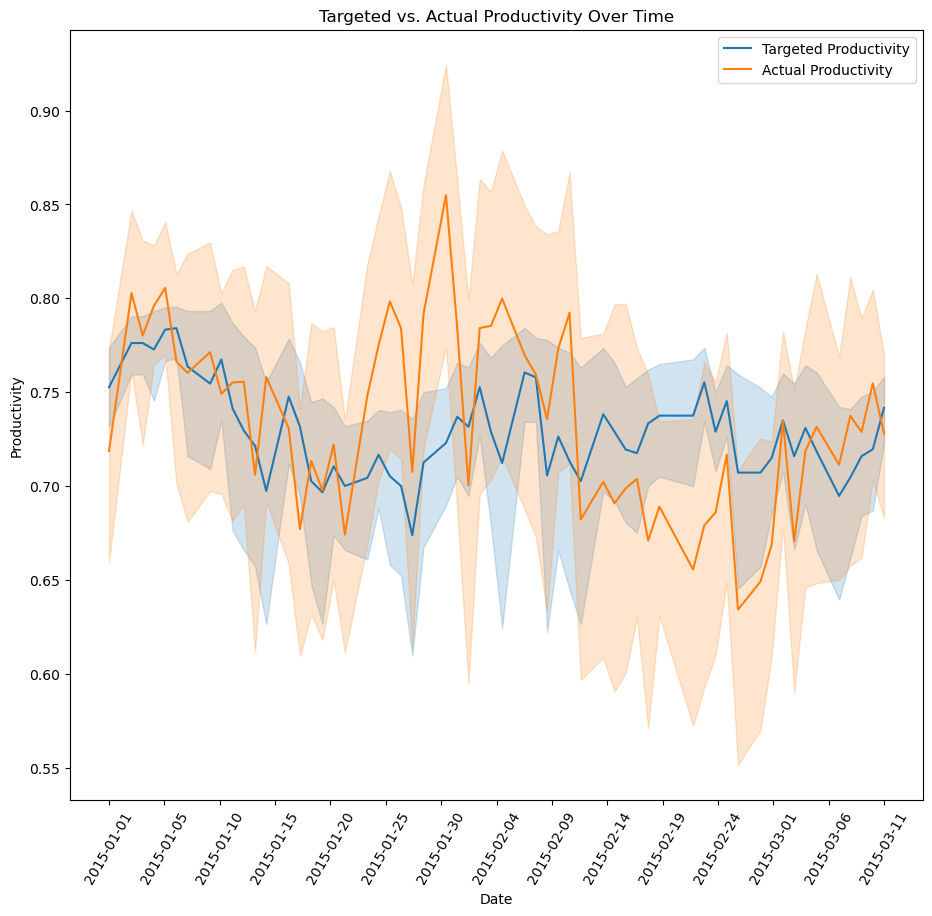

In [323]:
sns.lineplot(data=df, x='date', y='targeted_productivity', label='Targeted Productivity')
sns.lineplot(data=df, x='date', y='actual_productivity', label='Actual Productivity')

plt.title('Targeted vs. Actual Productivity Over Time')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Productivity')
df['date']=pd.to_datetime(df['date'],format = '%Y-%m-%d %H:%M:%S')
start_date = df['date'].min()
end_date = df['date'].max()
date_ticks = pd.date_range(start=start_date, end=end_date, periods=15)
plt.xticks(date_ticks, rotation=60)
plt.legend()
plt.show()

- In overall , the `actual_productivity` was greater than `targeted_productivity` during the period of 1/20/2015 to 2/4/2015 with few downs. 
- Period of 2/9/2015 to 3/1/2015 had in overall lesser `actual_productivity` than the `targeted_productivity`.

### Cleaning the Dataset 

#### Replacing Values

In [324]:
# Cleaning the duplicate classes of the `department` column by remving white spaces
clean_df=df.copy()
clean_df['department']=clean_df['department'].str.strip()
clean_df['department'].value_counts()

sweing       691
finishing    506
Name: department, dtype: int64

- After removing the white spaces, `department` contains only one category of `finishing` class.

In [325]:
# Merging Quarter5 with Quarter4
print('Before cleaning:')
display(clean_df['quarter'].value_counts())
print('After cleaning:')
clean_df['quarter']=clean_df['quarter'].str.replace('Quarter5','Quarter4')
clean_df['quarter'].value_counts()

Before cleaning:


Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: quarter, dtype: int64

After cleaning:


Quarter1    360
Quarter2    335
Quarter4    292
Quarter3    210
Name: quarter, dtype: int64

- Before cleaning the `quarter` columns, there were 44 observations that accounted for `Quarter5` category which was only created for last two days of the month of January. 
- It was not clear why there were five quarters only for month of January and all other months has four quarters as described in the definition of `quarter`. 
- 44 observations is a lesser number compared to number of observations in all other quarter groups, so that merging `Quarter5` with `Quarter4` is a better idea. 
- After merging these two classes, in total `Quarter4` contans 292 observations. 

#### Dropping Columns

***wip* : Handling Missing Values**

- It was discovered during data exploration, that `wip` column had 506 missing values. 
- Previuously it was assumed, those missing values could represent instances when there were no unfinished items for products were left, which implied that those values could be replaced as zero. 
- In order to confirm this idea, we can check if there are any `idle_men` or `idle_time` present in those observations, which verifies workers were idle or production was idle to support the instance of not having any unfinished items left. 

In [326]:
display(clean_df[clean_df['wip'].isna()]['idle_men'].value_counts())

0    506
Name: idle_men, dtype: int64

In [327]:
display(clean_df[clean_df['wip'].isna()]['idle_time'].value_counts())

0.0    506
Name: idle_time, dtype: int64

In [328]:
display(clean_df[clean_df['wip'].isna()]['department'].value_counts())

finishing    506
Name: department, dtype: int64

In [329]:
display(clean_df[(clean_df['wip'].isna() & clean_df['department']=='finishing')]['idle_men'].value_counts())

Series([], Name: idle_men, dtype: int64)

In [330]:
display(clean_df[(clean_df['wip'].isna() & clean_df['department']=='finishing')]['idle_time'].value_counts())

Series([], Name: idle_time, dtype: int64)

- `wip` was zero, for all observations recorded for `finishing` department.
- When there was no `wip` in the `finishing` department, there was no `idle_time` or `idle_men`. 
- There were 506 workers working in factory and and 506 observations factory was running without any idle time in the entire factory when there was no `wip`.
- This indicates the contracdition to replace the nan values of the `wip` column with zeros, instead this entire columns should be dropped. 

In [331]:
clean_df.drop('wip', axis=1, inplace=True)
print('wip' in clean_df.columns)

False


***idle_men & idle_time***

- `idle_men` represents number of workers who were idle and `idle_time` columns represents total time production was idle due to interruptions.
- However, there are only few instances where there were non-zero records for each of the columns and more than 70% of the data were instances where there were no `idle_men` or `idle_time` with having zero values for most observations. 
- So,that these two columns are non-infromative in data analysis process and should be dropped. 

In [332]:
clean_df.drop(columns=['idle_men','idle_time'],axis=1,inplace=True)
print('idle_men' in clean_df.columns)
print('idle_time' in clean_df.columns)

False
False


***date***

- Although`date` columns provides the information about the time period of observations are collected, it has a minimal predictive power because data only covers two and half months of a particular year. 
- It could have provided more meaningful information regarding the productivity during every season of the year, if date column consisited of all 12 months of a year.
- So, that `date` column should also be dropped.

In [333]:
clean_df.drop('date',axis=1,inplace=True)
print('date' in clean_df.columns)

False


#### Creating New Columns

- `actual_productivity` and `target_productivity`  are similar columns which both represents the main outcome of the project which is measure of productivity of employees.
- Somehow, since the goals is to determine if the targeted productivity set by the business is acheived by the actual productivity performed by workers, a new column called `target_acheived` indicating this acheivement would be more informative and would consist information from the both columns.
- Lastly, `actual_productivity` column can be dropped as the dataset already contain two other columns (*targeted_productivity & target_acheived*) that contain the same information which it brrought.

In [334]:
# Exploring targeted_productivity column
clean_df['targeted_productivity'].value_counts(normalize=True) * 100

0.80    45.112782
0.70    20.217210
0.75    18.045113
0.65     5.263158
0.60     4.761905
0.50     4.093567
0.35     2.255639
0.40     0.167084
0.07     0.083542
Name: targeted_productivity, dtype: float64

- more than 80% of the observations have targeted_productivity above 0.75.
- There is less than 1% chance having a very small tageted_productivity  value of 0.07 which seems a outlier  from all other classes of the targeted_productivity. 
- So, it can be considered that, 0.07 value was mistyped for 0.7 value in targeted productivity and so that 0.07 should be firstly replaced as 0.7

In [335]:
clean_df=clean_df.replace(to_replace=0.07,value=0.70)

In [336]:
clean_df['target_achieved'] = clean_df.apply(lambda x: 1 if x['actual_productivity'] >= x['targeted_productivity'] else 0, axis=1)
display(clean_df['target_achieved'].value_counts(normalize=True))

1    0.730159
0    0.269841
Name: target_achieved, dtype: float64

In [337]:
# Dropping the actual_productivity column.
clean_df.drop('actual_productivity',axis=1,inplace=True)
print('actual_productivity' in clean_df)

False


#### Rearranging the column names

In [338]:
clean_df=clean_df[['quarter', 'day', 'department', 'team', 'no_of_workers', 'over_time','no_of_style_change',
                     'smv', 'incentive', 'targeted_productivity','target_achieved']]
display(clean_df.head())

,quarter,day,department,team,no_of_workers,over_time,no_of_style_change,smv,incentive,targeted_productivity,target_achieved
0,Quarter1,Thursday,sweing,8,59.0,7080,0,26.16,98,0.80,1
1,Quarter1,Thursday,finishing,1,8.0,960,0,3.94,0,0.75,1
2,Quarter1,Thursday,sweing,11,30.5,3660,0,11.41,50,0.80,1
3,Quarter1,Thursday,sweing,12,30.5,3660,0,11.41,50,0.80,1
4,Quarter1,Thursday,sweing,6,56.0,1920,0,25.90,50,0.80,1


### Exploratory Data Analysis

#### Feature Selection

Using various various visualization techniques and feature engineering methods to understand patterns and correlationships that denotes the relevance of each variable to the classification problem.

In [339]:
categorical_columns = ['quarter', 'department', 'day', 'team', 'no_of_style_change']
numerical_columns = ['smv', 'over_time', 'incentive', 'no_of_workers']

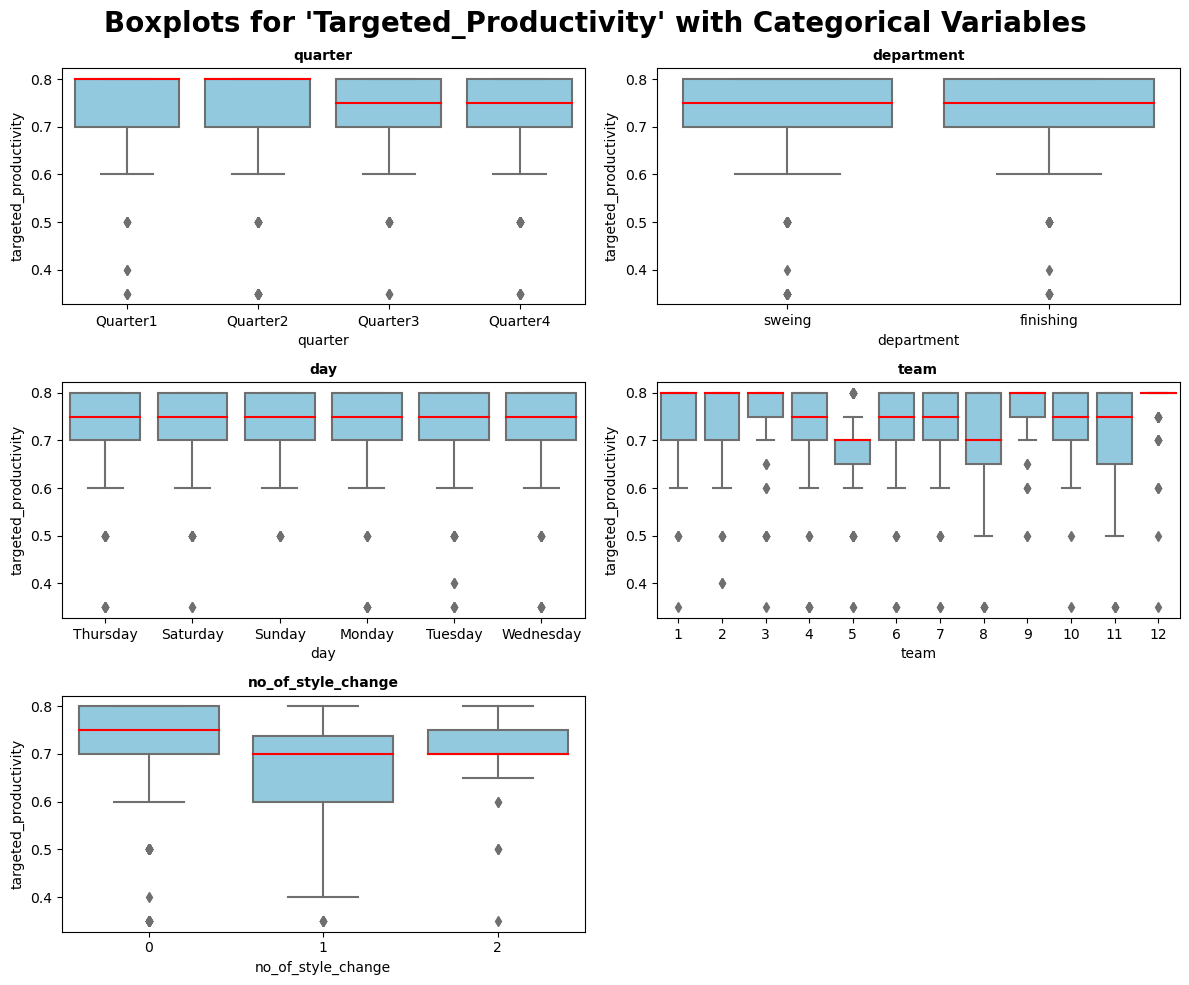

In [340]:
# Visualizing the relationship of categorical columns to the target variable `targeted_productivity'

fig,ax=plt.subplots(3,2,figsize=(12,10))
ax=ax.flatten()

fig.suptitle('Boxplots for \'Targeted_Productivity\' with Categorical Variables',fontsize=20,weight='bold')

for i,cat in enumerate(categorical_columns):
    sns.boxplot(x=cat,y='targeted_productivity',data=clean_df,ax=ax[i],color='skyblue',medianprops={'color': 'red'})
    ax[i].set_title(cat,fontsize=10,weight='bold')
ax[5].axis('off')
plt.tight_layout()
plt.show()
    


- There seems to be no impact by the day of the week on the targeted productivity.
- Every team has instances of less productivity which are mainly outliers.
- Both deartments have equal impact on the productivity.
- With the increase of the number of style chnages, the productivity has started getting decrease.
- During the last two quarters average productivity was less compared to first two quarters which had he same impact on the productivity.

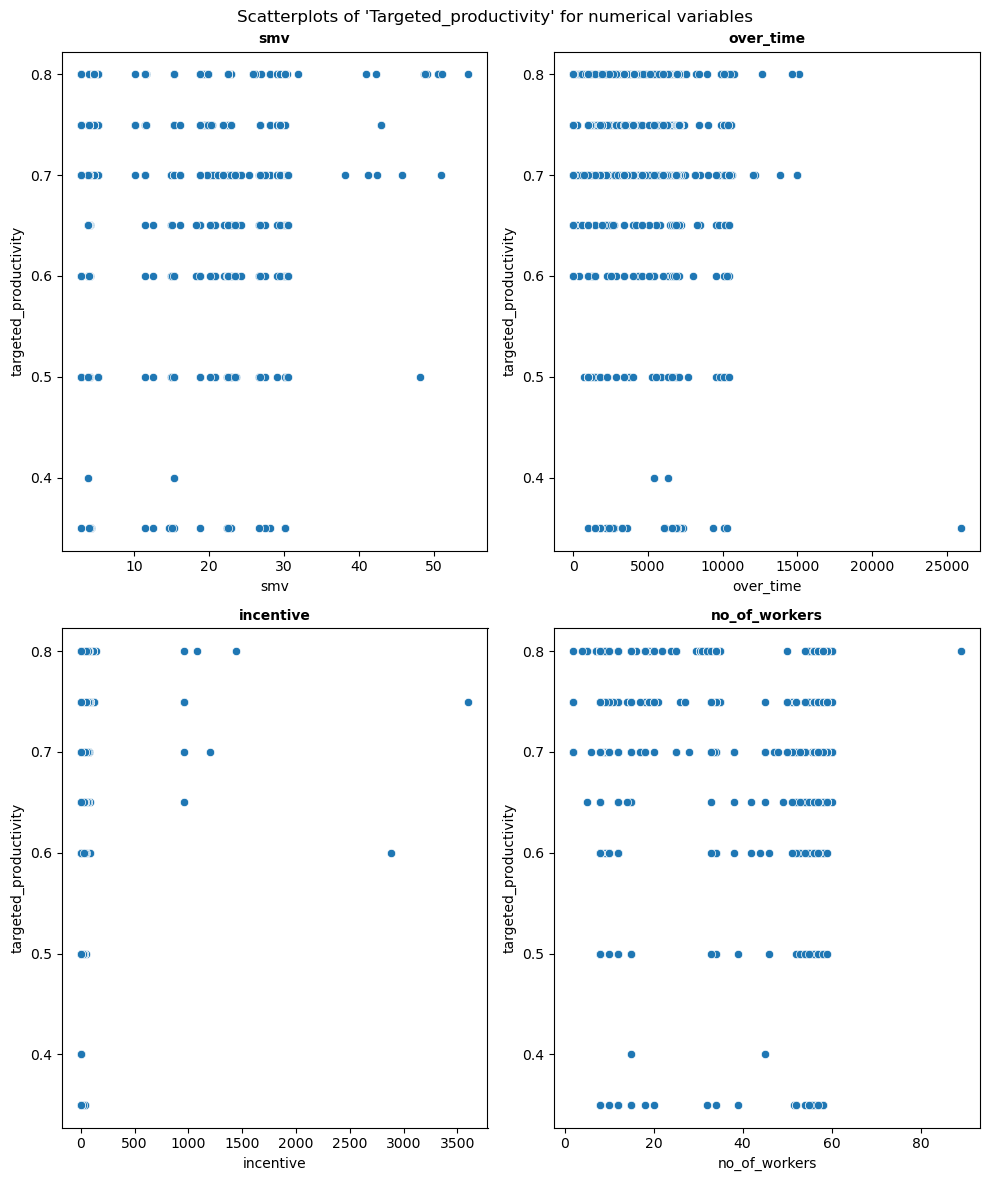

In [341]:
# Plotting the relationship between numerical variables with the taget variable 'targted_productivity'
fig,ax=plt.subplots(2,2,figsize=(10,12))
ax=ax.flatten()
fig.suptitle('Scatterplots of \'Targeted_productivity\' for numerical variables')

for i,col in enumerate(numerical_columns):
    sns.scatterplot(x=col,y='targeted_productivity',data=clean_df,ax=ax[i])
    ax[i].set_title(col,fontsize=10,weight='bold')
plt.tight_layout()
plt.show()
    
    


- There seems to be no pattern made by any of the numerical columns with the target variable which is targted_productivity. 
- Irrespective of the number of workers, they are yeilding the high productivity or same productivity as higher number of workers.
- Even at the incetive of zero, the productivity seems to be spread across all level ranging from 0 to 0.8.
- Irrespective of the amount of hours in the overtime, there are instances where mostly the same levels of productivity was acheived.

#### Feature Transformation
Since the machine learning model only accepts numerical data, all categorical columns should be converted to numerical dtype using **make_column_transfer** with **OneHotEncoder** and **OrdinalEncoder**

In [342]:
transform_cols=make_column_transformer((OneHotEncoder(),['department', 'day', 'team', 'no_of_style_change']),
                                                         (OrdinalEncoder(),['quarter']),remainder='passthrough',
                                       verbose_feature_names_out= False)
                                                        
transform_df=transform_cols.fit_transform(clean_df)
col_names=transform_cols.get_feature_names_out()
final_df=pd.DataFrame(transform_df,columns=col_names)
display(final_df.head())                                                                                                                                                                                                                                                                                                                                                                                             

,department_finishing,department_sweing,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,team_1,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12,no_of_style_change_0,no_of_style_change_1,no_of_style_change_2,quarter,no_of_workers,over_time,smv,incentive,targeted_productivity,target_achieved
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,59.0,7080.0,26.16,98.0,0.80,1.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,960.0,3.94,0.0,0.75,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,30.5,3660.0,11.41,50.0,0.80,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,30.5,3660.0,11.41,50.0,0.80,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,56.0,1920.0,25.90,50.0,0.80,1.0


### Building the Model

- This project  can be done using the both tree models, creating two scenarios for prediction. 
- **DecisionTreeClassifier** model is used to build classifier to predict the class of target variable `target_acheived`.
- **DecisionTreeRegresor** model is used to predict the constinuous value of the target variable `targeted_productivity`.
- The main focus of this project is to build a classifier which is able to predict the `target_acheived` column with least misclassification rate/impurity.

#### Building the DecisionTreeClassifier 

In [343]:
X=final_df.drop(columns=['targeted_productivity','target_achieved'],axis=1)
y=final_df['target_achieved']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=72)
class_tree=DecisionTreeClassifier(criterion='gini',random_state=72,max_depth=3)
class_tree.fit(X_train,y_train)
training_accuracy=class_tree.score(X_train,y_train)*100
test_accuracy=class_tree.score(X_test,y_test)*100
print(f'model\'s training accuracy:{training_accuracy}')
print(f'model\'s test accuracy :{test_accuracy}')

model's training accuracy:82.34064785788924
model's test accuracy :78.75


- As expected, model's test accuracy is lesser than training accuracy as the model is more generalized when using the unseen data. 
- However, the test accuracy of 78.85 % could be improved using  pre-pruning or post_pruning methods on the decision tree.

#### Minimum cost complexity pruning(post-pruning the decision tree)

- The goal of using this cost path is to create diverse subtrees and to find the subtree with the highest scroing accuracy. 
- At that point alpha value iss considered as the optimal alpa value for the **ccp_alpha** parameter which uses to adds a penalty for subtrees that produce large number of leaves that causes overfitting of the data.

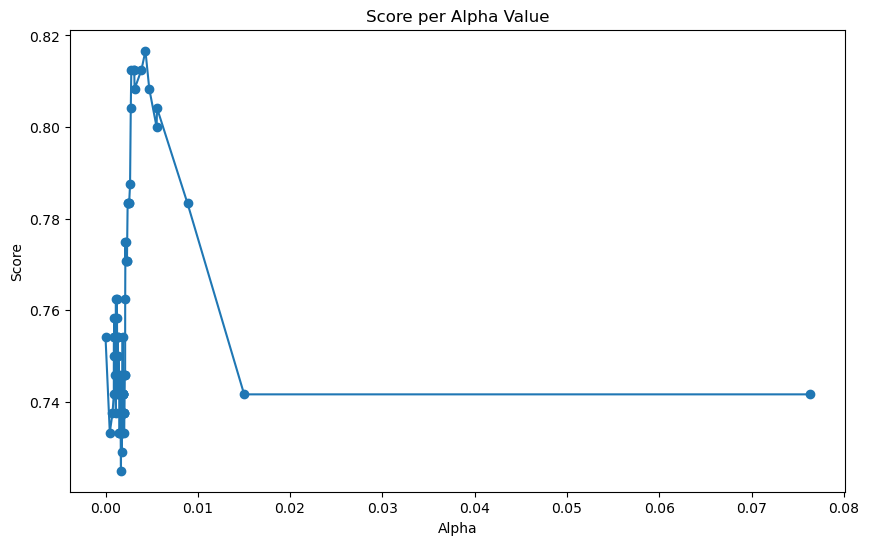

model's validation accuracy: 81.66666666666667
model's test accuracy: 81.66666666666667


In [344]:
unpruned_tree = DecisionTreeClassifier()

X_train, X_val, y_train, y_val = train_test_split(X , y, test_size = 0.2, random_state=72)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2 * X.shape[0]/X_train.shape[0],
                                                    random_state=72)

cost_path = unpruned_tree.cost_complexity_pruning_path(X_train, y_train)

subtrees = []
for alpha in cost_path.ccp_alphas:
    subtree = DecisionTreeClassifier(ccp_alpha=alpha)
    subtree.fit(X_train, y_train)
    subtrees.append(subtree)    
subtree_scores= [subtree.score(X_val,y_val) for subtree in subtrees]



# Visualization of score with alpha values

plt.rcParams['figure.figsize'] = [10, 6]
fig, ax = plt.subplots()
ax.set_xlabel('Alpha')
ax.set_ylabel('Score')
ax.set_title('Score per Alpha Value')
ax.plot(cost_path.ccp_alphas, subtree_scores, marker='o')
plt.show()

#Getting maximum score and finding the best subtree
alpha_scores = tuple(zip(cost_path.ccp_alphas, subtree_scores))
val_accuracy=max(alpha_scores, key=lambda x:x[1]) 
print(f'model\'s validation accuracy: {val_accuracy[1]*100}')

# Finding the accuracy of the best pruned tree
best_score_index = np.argmax(subtree_scores)
best_pruned_tree = subtrees[best_score_index]

test_score = best_pruned_tree.score(X_test, y_test)
print(f'model\'s test accuracy: {test_score*100}')

In [345]:
best_pruned_tree.classes_

array([0., 1.])

- By using minimal cost complexity pruning method, test accuracy of the model was increased up to 82% 

#### Plotting the Decision Tree

The `target_acheived` has two classes **'Yes'** and **'No'** which were transformed to numericals of  0 and 1 to train the model. When plotting the best pruned classification decision tree, the names of the above classes are used.

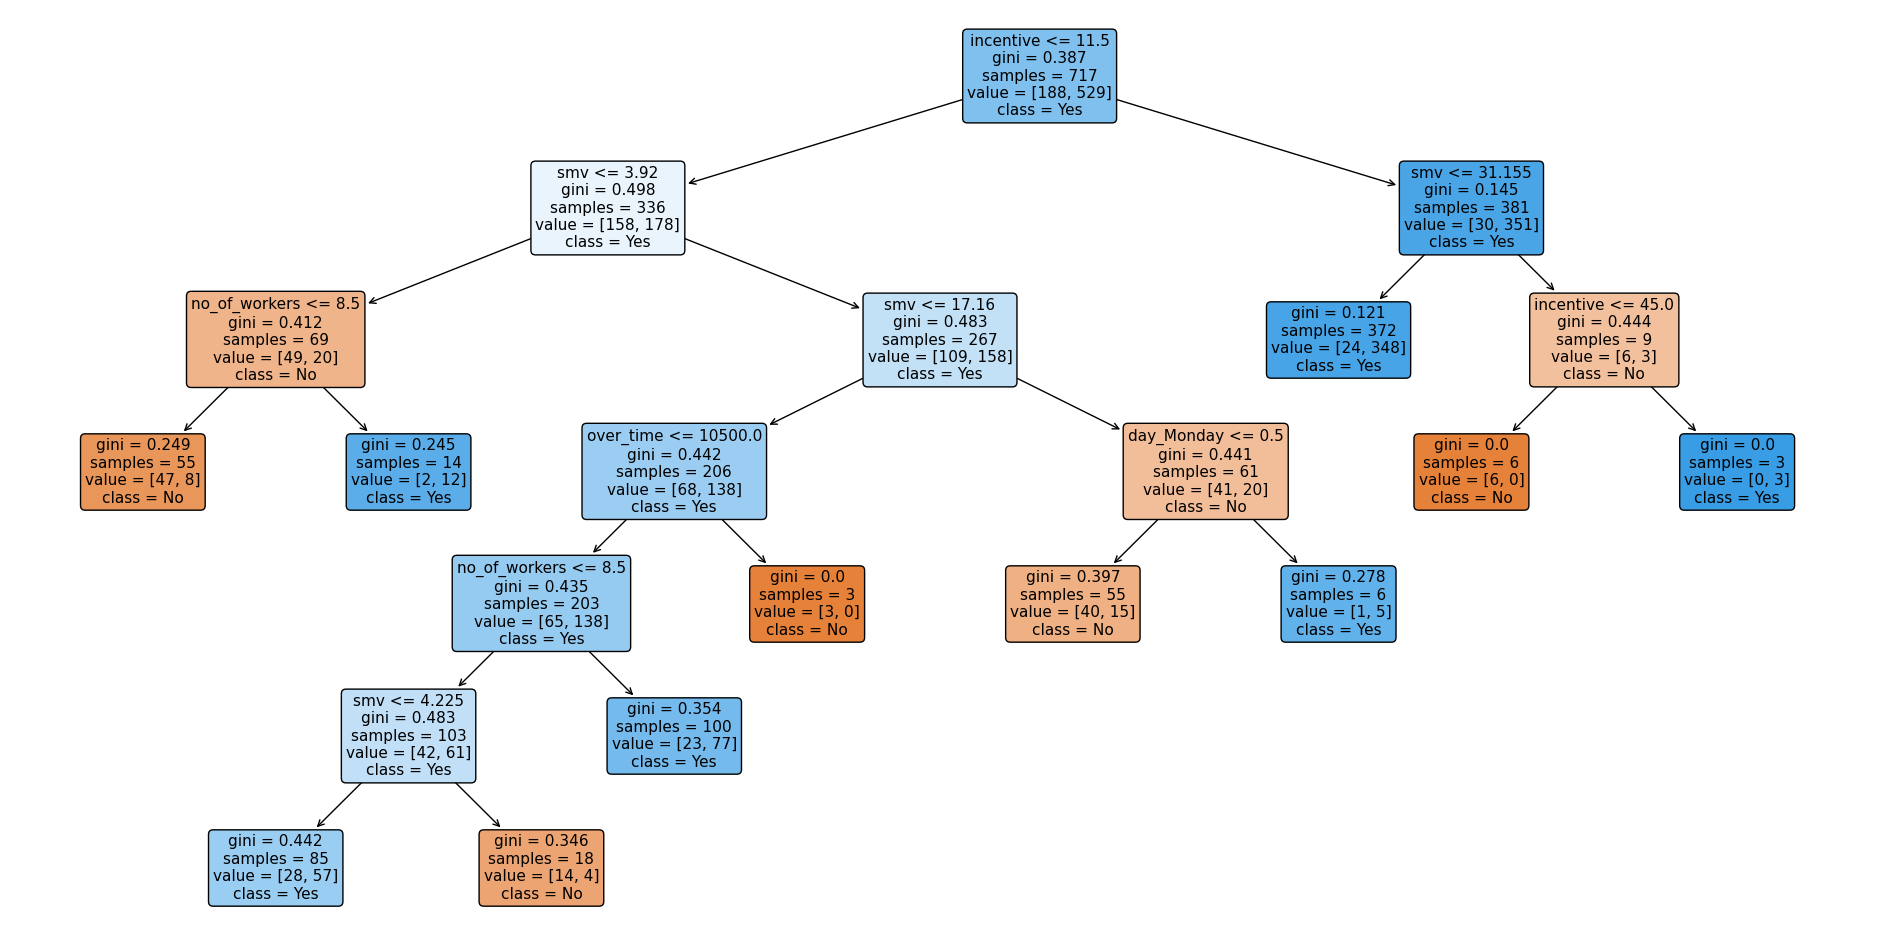

In [346]:
classes = ['No','Yes']
plt.figure(figsize = [24, 12]) 

plot_tree(best_pruned_tree, 
          feature_names = X.columns.tolist(),
          class_names = classes, 
          filled = True,       
          proportion = False,
          precision = 3,
          rounded = True,
          fontsize = 11)

plt.show()

Decision trees are a tool use to evaluate which factors are most impactful when pedicting the classification or regression outcome. In this project,the classification decision trees are built and trained using the previous production data and seeing which factors are associated with the success or failure of the classification task and graphically represent the relationship of those factors with the classification outcome.

Decision trees are split into two branches at each node, depending on the decision resulted from the threshold of the selected feature at the node.True outcome of the split would always progress to the left and False outcomes to the right of the split.Terminal nodes, contain leaves which contain only homogenous group of the class and represents the possible decision based on a specific factor.

This graphical representation would helpful in understanding the value of each attribute to the classificatin task.It can be seen `incetive`,`smv`,`no_of_workers` are the best impactful attributes as they appear multiple times in the decision tree diagram contributing the decisions made at the terminal leaf.

So, Decision Trees are a powerful and efficient tool that gives a clear picture on which factors have most importance on the desired outcomes of the production process and those factors can be included in making business decisions and planning to improve the productivity of the production process.

#### Model Evaluation 

#### Evaluating the accuracy of the pruned tree

In [347]:
y_predict=best_pruned_tree.predict(X_test)
class_report=classification_report(y_test,y_predict)
print(f'classification report:{class_report}')

classification report:              precision    recall  f1-score   support

         0.0       0.84      0.49      0.62        73
         1.0       0.81      0.96      0.88       167

    accuracy                           0.82       240
   macro avg       0.82      0.73      0.75       240
weighted avg       0.82      0.82      0.80       240



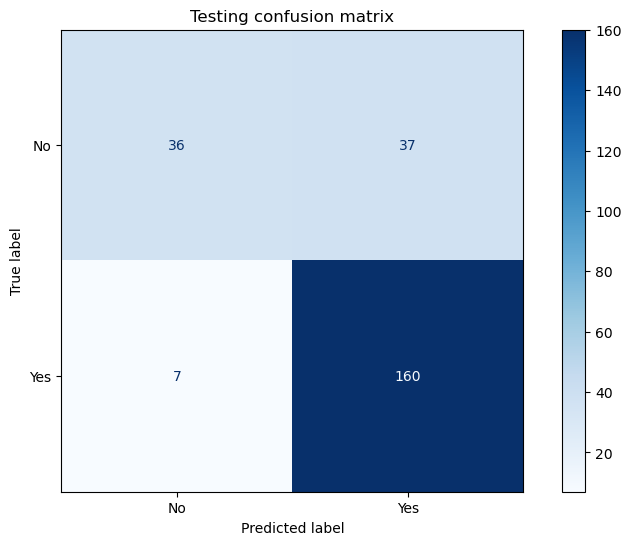

pruned Tree's sensitivity: 95.80838323353294
Pruned Tree's specificity: 49.31506849315068


In [348]:
confusion=confusion_matrix(y_test,y_predict)
display=ConfusionMatrixDisplay(confusion,display_labels=classes)                           
display.plot(cmap="Blues")
plt.grid(False)
plt.title('Testing confusion matrix')
plt.show()

TP=confusion[1,1]
FP=confusion[0,1]
TN=confusion[0,0]
FN=confusion[1,0]

Sensitvity=TP/(TP+FN)
print(f'pruned Tree\'s sensitivity: {Sensitvity*100}')
Specificity=TN/(TN+FP)
print(f'Pruned Tree\'s specificity: {Specificity*100}')

- Looking at both classification report and confusion matrix, it can be seen , model has a significantly **high sensitivity/recall** compared to specificity.
- It indicates model is great at correctly classifying postive classes, which is if the target production was acheived, rather than classifying the negative class.

#### Evaluating the feature Importance

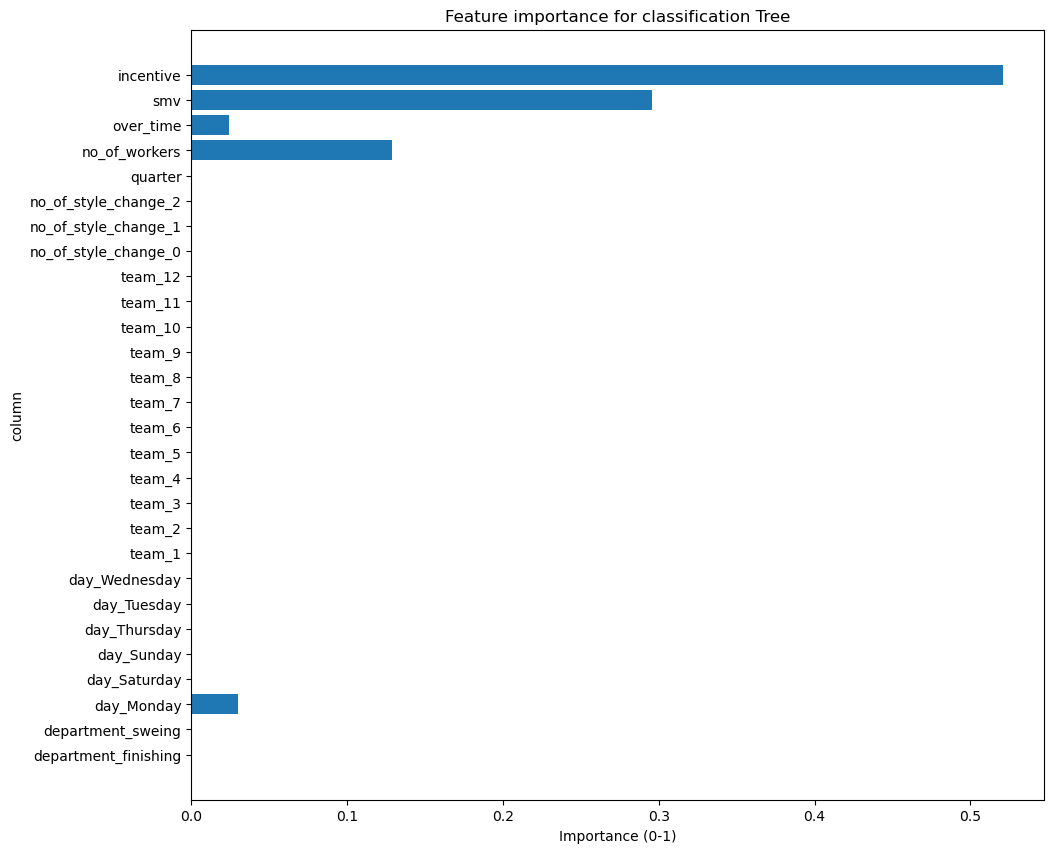

In [349]:
#Plotting the feature importance
best_pruned_tree.fit(X_train,y_train)
plt.rcParams['figure.figsize']=[11.0,10.0]
plt.barh(best_pruned_tree.feature_names_in_,best_pruned_tree.feature_importances_)
plt.xlabel("Importance (0-1)")
plt.ylabel("column")
plt.title("Feature importance for classification Tree")
plt.show()

- Similar to results gained by evaluating the decision tree, it can be seen that `incentive` attribute has the highest impact on the productivity in the production process. 
- Also `smv` and `no_of_workers` have a considerable impact on the productivity along with `day_Monday` and `over_time` as two other attributes with certain impact.
- None of the other attributes have made any impact on the productivity of the production process. 
- So, the other attributes can be eliminated and reduce the model complexity when developing a optimal model with higher accuracy score.

#### Comparison of the accuracy with RandomeForestClassifier model 

Although important attributes are identified by the feature selection, here the same attributes used in the DecisionTreeClassifier model are used,to derrive an unbiased comparison on the accuracy gained from each model.

In [350]:

# Instantiate Random Forest Classifier
random_tree = RandomForestClassifier(oob_score=True, random_state=42)
random_tree.fit(X_train, y_train)
rt_y_predict= random_tree.predict(X_test)

print(f'Test accuracy from RandomForest Model:{accuracy_score(y_test,rt_y_predict)*100}')



Test accuracy from RandomForest Model:80.83333333333333


- There is not much difference between the accuracies of the models.
- The test accuracy gained from RandomForestClassifier is only a one value off from the test accuracy gained from the best pruned decision tree. 

#### GridSearchCV method of Hyperparameter Tuning (Pre-pruning the Decision Tree)

When using the GridSerchCV method, to reduce the complexity of the model, the attributes of the model can be reduced to the selected features from the feature selection process. 

In [351]:

'''weak_class_tree=DecisionTreeClassifier(random_state=24)
X=clean_df[['incetive','smv','over_time','no_of_workers','day_Monday']]
y=clean_df['target_acheived']
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state=72)

params = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search=GridSearchCV(weak_class_tree,cv=6,n_jobs=-1,param_grid=params,scoring='accuracy')
grid_search.fit(X_train,y_train) 
                         
print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'Best accuracy score: {round(grid_search.best_score_, 2)}') '''                       

"weak_class_tree=DecisionTreeClassifier(random_state=24)\nX=clean_df[['incetive','smv','over_time','no_of_workers','day_Monday']]\ny=clean_df['target_acheived']\nX_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state=72)\n\nparams = {\n    'max_depth': [None, 5, 10],\n    'min_samples_split': [2, 5],\n    'min_samples_leaf': [1, 2]\n}\ngrid_search=GridSearchCV(weak_class_tree,cv=6,n_jobs=-1,param_grid=params,scoring='accuracy')\ngrid_search.fit(X_train,y_train) \n                         \nprint(f'Best hyperparameters: {grid_search.best_params_}')\nprint(f'Best accuracy score: {round(grid_search.best_score_, 2)}') "

### Conclusion

To fulfil the goal of this project sequence of steps were perfomed from explore and preprocess the dataset to build a decision tree model and evaluate its performance to improve the model's accuracy using ensemble modeling and using random forest algorithm. 

One of the most important takeaways from this project is the importance of feature selection and preprocessing in improving model performance. By analyzing the relationships between different features and the target variable, we were able to identify the most important features and discard the less relevant ones. Additionally, by using techniques such as one-hot encoding and scaling, we were able to transform the data into a format that could be effectively used by the decision tree and random forest models.

Another important takeaway is that while ensemble methods such as random forests can improve the accuracy of a model, they are not always necessary. In this project, we found that the decision tree model was already quite robust and that the random forest model did not significantly outperform it in terms of accuracy. Therefore, it is important to carefully evaluate the performance of different models and choose the one that best fits the problem at hand.

Finally, we also learned about the importance of effective communication in data science. In this project, we used decision tree visualizations to communicate our findings to non-technical stakeholders, making it easy for them to understand the factors that were most important in determining the success or failure of a garment production run. Effective communication is essential for ensuring that data-driven insights are effectively used to inform decision-making and drive business success.